EARTHQUAKE ANALYSIS AND PREDICTIONS USING KALMAN FILTERS

What is a Kalman Filter?
The Kalman filter is a mathematical algorithm used for estimating and  predicting the state of a dynamic system from a series of noisy measurements. At its core, the Kalman filter combines predictions from a dynamic model of the
system's behavior with measurements of the system's state. It calculates an optimal estimate of the current state by minimizing the mean squared error between the predicted and measured values, considering both the uncertainty in the measurements and the dynamics of the system.

As our baseline, we built a model which simply calculated the kalman gain. The code is as follows.

In [ ]:
#!pip install obspy

In [ ]:
import csv
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Initialize client (IRIS -> It is one format of obtaining earthquake related data. There are others like GFZ)
client = Client("GFZ")

# Define start and end times
starttime = UTCDateTime(2010, 1, 1)
endtime = UTCDateTime(2024, 1, 1)

# Query to generate earthquake events between the specified time periods
cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=6.0)


csv_file = "earthquake_events.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header row
    writer.writerow(['Event ID', 'Origin Time', 'Latitude', 'Longitude', 'Depth (km)', 'Magnitude'])
    for event in cat:
        event_id = event.resource_id.id.split("/")[-1]
        origin_time = event.origins[0].time.datetime
        latitude = event.origins[0].latitude
        longitude = event.origins[0].longitude
        depth_km = event.origins[0].depth / 1000.0  # Convert depth to kilometers
        magnitude = event.magnitudes[0].mag
        writer.writerow([event_id, origin_time, latitude, longitude, depth_km, magnitude])

print(f"Earthquake events saved to {csv_file}")


Earthquake events saved to earthquake_events.csv


In [ ]:
import csv
import numpy as np

events = []
with open('earthquake_events.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    for row in reader:
        events.append([float(row[2]), float(row[3]), float(row[5])])  # Latitude, Longitude, Magnitude

# Kalman Filter Initialization
x = np.array([events[0][0], events[0][1], events[0][2]])  # Initial state estimate [latitude, longitude, activity level] -> this in mathematical terms is known as a state vector
P = np.eye(3)  # Initial error covariance matrix
Q = np.eye(3) * 0.1  # Process noise covariance matrix
R = 1.0  # Measurement noise covariance

# Kalman Filter Loop
estimated_states = []
for z in events:
    # Prediction Step
    F = np.eye(3)  # Identity matrix (used here as a transition matrix)
    x = np.dot(F, x)
    P = np.dot(np.dot(F, P), F.T) + Q

    # Update Step
    H = np.array([[0, 0, 1]])  # Measurement model: Magnitude reflects activity level
    K = np.dot(P, H.T) / (np.dot(np.dot(H, P), H.T) + R)
    x = x + np.dot(K.T, z - np.dot(H, x))
    P = np.dot(np.eye(3) - np.dot(K, H), P)

    estimated_states.append(x)

with open('estimated_states.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Estimated Latitude', 'Estimated Longitude', 'Estimated Activity'])
    for state in estimated_states:
        writer.writerow([state[0], state[1], state[2]])

print("Estimated states (Latitude, Longitude, Activity) saved to 'estimated_states.csv'")


Estimated states (Latitude, Longitude, Activity) saved to 'estimated_states.csv'


In the above snippet of code, we've initialized the necessary parameters for the Kalman filter (like state vector, co-variance matrix etc.) and start the kalman filter loop. However, since the data in itself is intermittent and discontinuous, the filter is not able to accurately predict the state of the system. It instead uses one single event to create an estimate of the state

To ensure that the above mentioned scenario does not occur, we are supposed to input time series data. To achieve this, we've explored two paths

1) Kalman Smoothening to convert the dataset into a time series

2) Obtaining a channel of time series waveform data

***1) Kalman smoothening***

Kalman smoothing is a technique used to improve the accuracy of state estimates by incorporating future information into the filtering process. Unlike Kalman filtering, which operates in real-time and uses only past measurements, smoothing considers both past and future measurements to refine the state estimates. It achieves this by running the Kalman filter forward in time to obtain predicted states and then backward in time to refine them using future measurements. Mathematically, it involves computing the optimal estimate of the state using a combination of the predicted state from the filtering step and the corrected state from the backward pass.

In [ ]:
import requests
import json

# API query parameters to filter earthquakes in Japan
parameters = {
    "format": "geojson",
    "starttime": "2022-01-01",
    "endtime": "2022-12-31",
    "minlatitude": "24.396308",
    "maxlatitude": "45.551483",
    "minlongitude": "122.93457",
    "maxlongitude": "153.986672"
}

response = requests.get("https://earthquake.usgs.gov/fdsnws/event/1/query", params=parameters)


if response.status_code == 200:
    # Process the earthquake data from the response
    earthquake_data = response.json()
    # Save the data to a file
    with open("japan_earthquake_data.json", "w") as f:
        json.dump(earthquake_data, f)
    print("Earthquake data downloaded successfully.")
else:
    print("Error: Failed to retrieve earthquake data.")


Earthquake data downloaded successfully.


In [ ]:
import pandas as pd

# Load the JSON data from the file
with open("japan_earthquake_data.json", "r") as f:
    data = json.load(f)

# Extracting the earthquake events from the JSON data
earthquake_events = data["features"]

# Creating a DataFrame from the earthquake events
df = pd.DataFrame(earthquake_events)

# Flatten the properties column
df_properties = pd.json_normalize(df["properties"])

# Combine the DataFrame with flattened properties
df_combined = pd.concat([df, df_properties], axis=1)

# Drop unnecessary columns
columns_to_drop = ["type", "tz", "felt", "cdi", "mmi", "properties", "id", "url", "detail", "code", "net", "magType", "ids", "sources", "types", "title", "alert", "status", "sig"]
df_combined.drop(columns=columns_to_drop, inplace=True)


df_combined.to_csv("japan_earthquake_data.csv", index=False)

print("CSV file created successfully.")

CSV file created successfully.


In this approach we've used the USGS dataset about earthquakes in Japan to initially restrict our area of study for better estimates.

In [ ]:
import ast  # for literal_eval function

df = pd.read_csv("/content/japan_earthquake_data.csv")

# Define a function to extract latitude and longitude from the JSON-like string
def extract_coordinates(json_str):
    data = ast.literal_eval(json_str)
    return pd.Series([data['coordinates'][1], data['coordinates'][0]])

# Apply the function to the column containing the JSON data
df[['Latitude', 'Longitude']] = df['geometry'].apply(extract_coordinates)
df.drop(columns=["geometry"], inplace=True) #dropping the original column as we've extracted required data

df.to_csv("/content/japan_earthquake_data.csv", index=False)

In [ ]:
#!pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 1.9 MB/s eta 0:00:00


In [ ]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd

# Load earthquake data from CSV file into a pandas DataFrame
input = pd.read_csv("/content/japan_earthquake_data.csv")

# Extract latitude, longitude, and magnitude from the input DataFrame
input_data = input[['Latitude', 'Longitude', 'mag']].values

# We define transition matrices A and observation matrices H
# Here we only model latitude, longitude, and magnitude, so A and H will be 3x3 matrices
dt = 2  # Time step in days
A = [[1, dt, 0],
     [0, 1, dt],
     [0, 0, 1]]

min_lat = 26
max_lat = 45
min_lon = 120
max_lon = 140 #This is an approximate of the extent of mainland Japan

# We adjust the transition matrices to enforce constraints
A[0][0] = max(min(A[0][0], max_lat), min_lat)
A[2][2] = max(min(A[2][2], max_lon), min_lon)
# Assuming we observe all state variables directly
H = np.eye(3)

# Process noise covariance matrix Q is defined
# This represents the uncertainty in the state transition process
# Here, we take a diagonal covariance matrix
Q = np.diag([0.01, 0.01, 0.01])

# Measurement noise covariance matrix R is defined
# This represents the uncertainty in the measurement process
# Here, we take a diagonal covariance matrix similar to Q
R = np.diag([0.1, 0.1, 0.1])

# Initializing Kalman filter
kf = KalmanFilter(transition_matrices=A,
                  observation_matrices=H,
                  transition_covariance=Q,
                  observation_covariance=R)

# Perform Kalman filtering
filtered_state_means, _ = kf.filter(input_data)

# Get the smoothed estimates of the state variables
smoothed_latitudes = filtered_state_means[:, 0]
smoothed_longitudes = filtered_state_means[:, 1]
smoothed_magnitudes = filtered_state_means[:, 2]

# Add smoothed latitude, longitude, and magnitude to the original DataFrame
input['Smoothed Magnitude'] = smoothed_magnitudes

# Save the DataFrame to a CSV file
input.to_csv("/content/smoothed_japan_earthquake_data.csv", index=False)


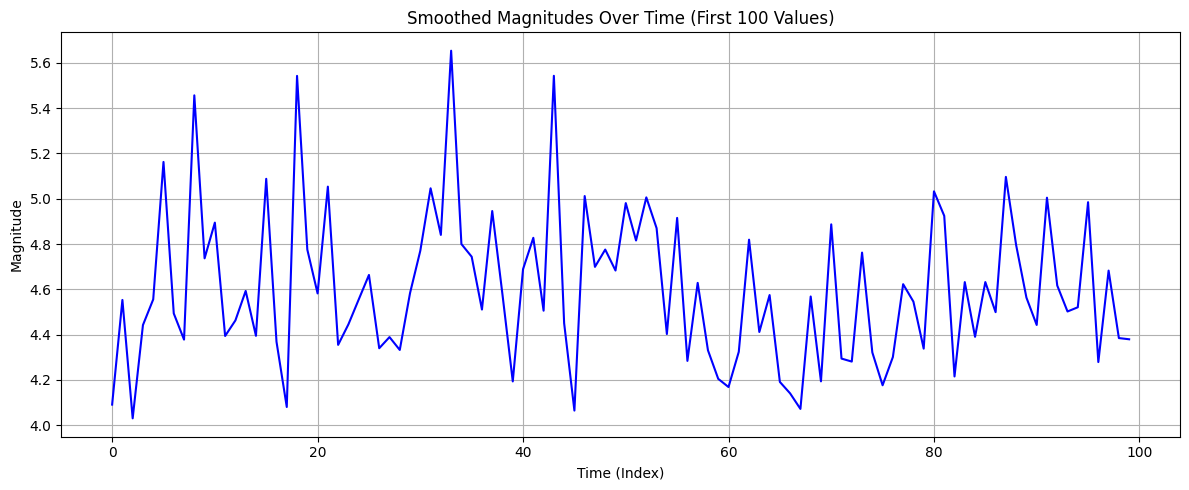

In [ ]:
import matplotlib.pyplot as plt

# Generate the x-axis values (indices) for the plot
indices = range(100)  # Selecting only the first 100 values

# Slice the smoothed magnitudes array to select the first 100 values
magnitudes_subset = df["mag"][:100]
smoothed_magnitudes_subset = smoothed_magnitudes[:100]

# Plotting both graphs side by side
plt.figure(figsize=(12, 5))
plt.plot(indices, smoothed_magnitudes_subset, color='blue')
plt.title('Smoothed Magnitudes Over Time (First 100 Values)')
plt.xlabel('Time (Index)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


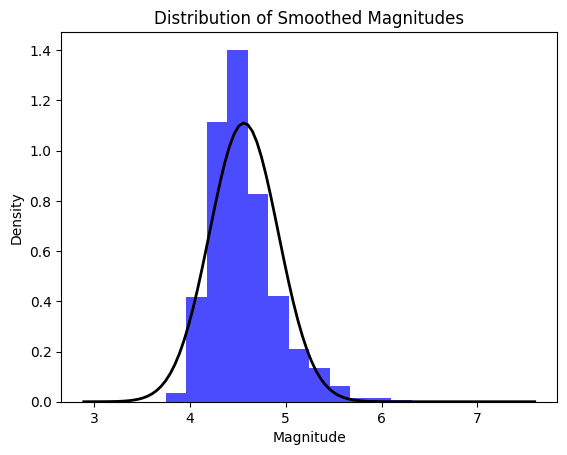

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Estimate parameters of the normal distribution
mu, std = norm.fit(smoothed_magnitudes)

# Plot histogram of smoothed magnitudes
plt.hist(smoothed_magnitudes, bins=20, density=True, color='blue', alpha=0.7)

# Plot the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.title('Distribution of Smoothed Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Density')

# Show plot
plt.show()

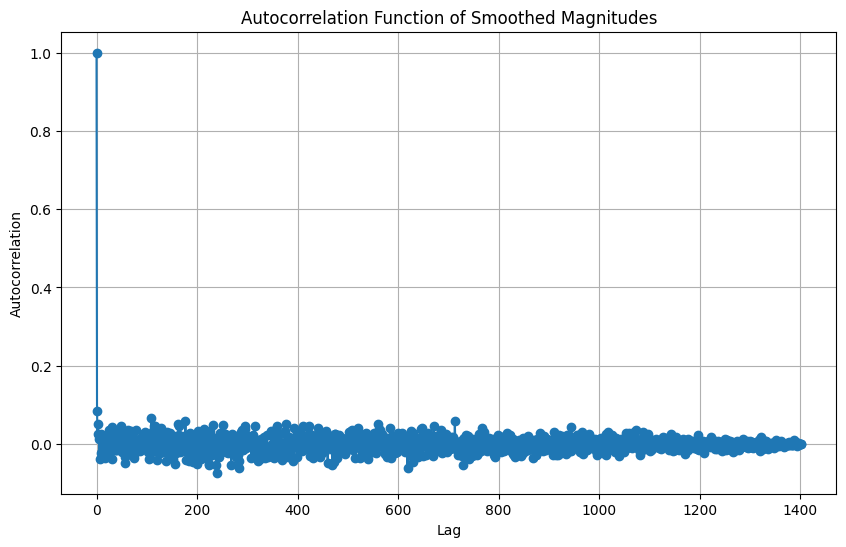

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute autocorrelation function (ACF)
def autocorr(x):
    """
    Compute autocorrelation function (ACF) for a 1D array.

    Parameters:
    - x: 1D numpy array representing the time series data.

    Returns:
    - acf: Autocorrelation function values.
    """
    n = len(x)
    mean = np.mean(x)
    var = np.var(x)
    acf = np.correlate(x - mean, x - mean, mode='full') / (var * n)
    return acf[n-1:]

# Compute autocorrelation for smoothed magnitudes
acf = autocorr(smoothed_magnitudes)

# Plot autocorrelation function
plt.figure(figsize=(10, 6))
plt.plot(acf, marker='o', linestyle='-')
plt.title('Autocorrelation Function of Smoothed Magnitudes')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [ ]:
# Plot autocorrelation function with adjusted y-axis scale
plt.figure(figsize=(200, 45))
plt.plot(acf, marker='o', linestyle='-')
plt.title('Autocorrelation Function of Smoothed Magnitudes')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(0, 0.1)  # Set y-axis limits
plt.grid(True)
plt.show()

[4.51353297 4.53119178 4.53262332 4.53273937 4.53274878 4.53274954
 4.53274961 4.53274961 4.53274961 4.53274961 4.53274961 4.53274961]
[34.28774336 34.5975574  34.66156729 34.67479221 34.67752458 34.67808911
 34.67820574 34.67822984 34.67823482 34.67823585 34.67823606 34.6782361
 34.67823611 34.67823611 34.67823611 34.67823611 34.67823611 34.67823611
 34.67823611 34.67823611 34.67823611 34.67823611 34.67823611 34.67823611
 34.67823611 34.67823611 34.67823611 34.67823611 34.67823611 34.67823611]
[133.11914481 133.40650079 133.65898942 133.88084145 134.07577429
 134.24705427 134.39755139 134.52978741 134.64597811 134.7480704
 134.83777497 134.91659491 134.98585096 135.04670359 135.10017245
 135.14715347 135.18843389 135.2247054  135.25657579 135.28457906
 135.30918446 135.33080428 135.34980078 135.36649228 135.38115845
 135.39404505 135.40536801 135.41531706 135.42405891 135.43174003
 135.43848914 135.44441932 135.44962994 135.45420831 135.45823115
 135.46176587 135.46487168 135.46760065

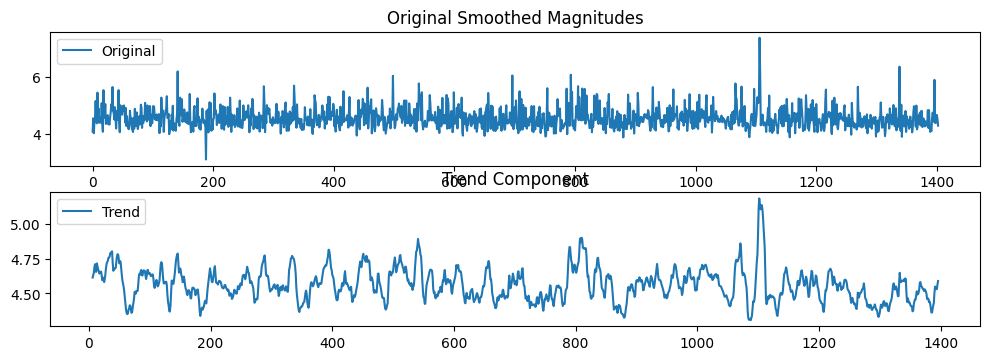

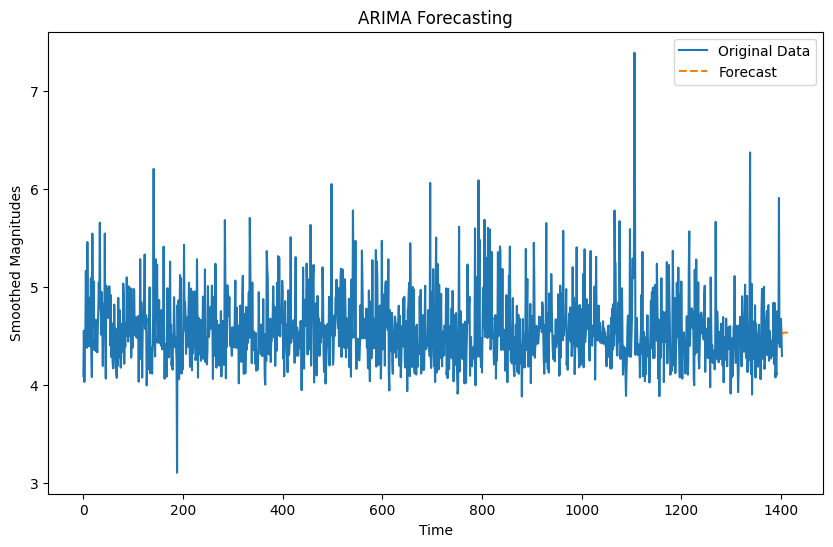

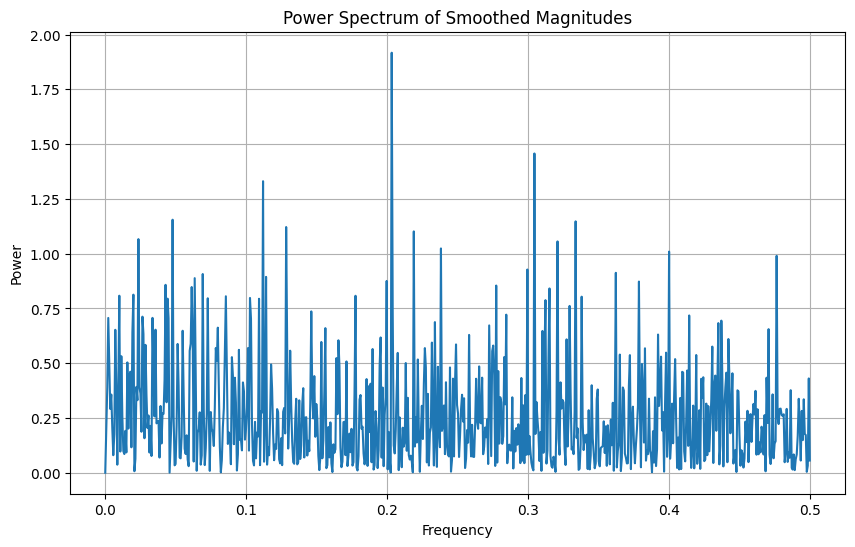

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import periodogram

# Load earthquake data from CSV file into a pandas DataFrame
input_data = pd.read_csv("/content/japan_earthquake_data.csv")

# Perform seasonal decomposition
decomposition = seasonal_decompose(smoothed_magnitudes, period=12)  # Assuming yearly seasonality
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(smoothed_magnitudes, label='Original')
plt.legend(loc='upper left')
plt.title('Original Smoothed Magnitudes')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')


# Perform ARIMA forecasting
model = ARIMA(smoothed_magnitudes, order=(1, 1, 1))  # Example ARIMA(1,1,1) model
fit_model = model.fit()
forecast = fit_model.forecast(steps=12)  # Forecast next 12 time points
print(forecast)

model1 = ARIMA(smoothed_latitudes, order=(1, 1, 1))  # Example ARIMA(1,1,1) model
fit_model = model1.fit()
forecast1 = fit_model.forecast(steps=30)
print(forecast1)

model2 = ARIMA(smoothed_longitudes, order=(1, 1, 1))  # Example ARIMA(1,1,1) model
fit_model = model2.fit()
forecast2 = fit_model.forecast(steps=100)
print(forecast2)

# Plot original data and forecast
plt.figure(figsize=(10, 6))
plt.plot(smoothed_magnitudes, label='Original Data')
plt.plot(np.arange(len(smoothed_magnitudes), len(smoothed_magnitudes) + 12), forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Forecasting')
plt.xlabel('Time')
plt.ylabel('Smoothed Magnitudes')
plt.show()

# Perform spectral analysis
frequencies, power_spectrum = periodogram(smoothed_magnitudes)
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Power Spectrum of Smoothed Magnitudes')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

**Approach 2**

In [ ]:
#!pip install obspy

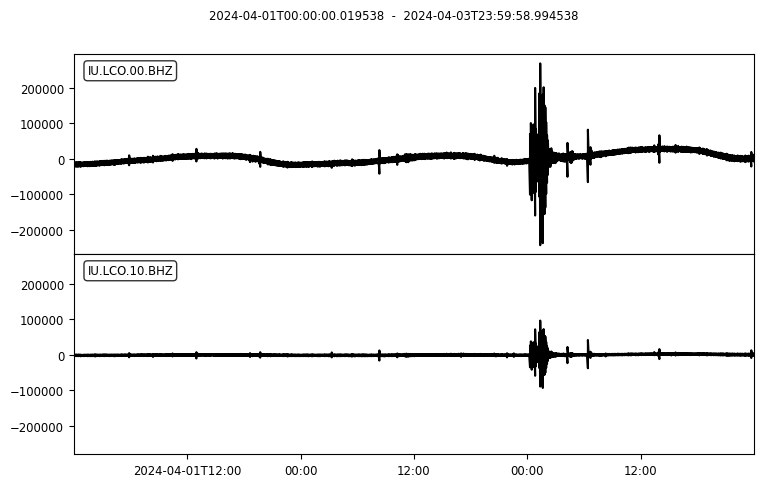

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  fig.canvas.print_figure(bytes_io, **kw)


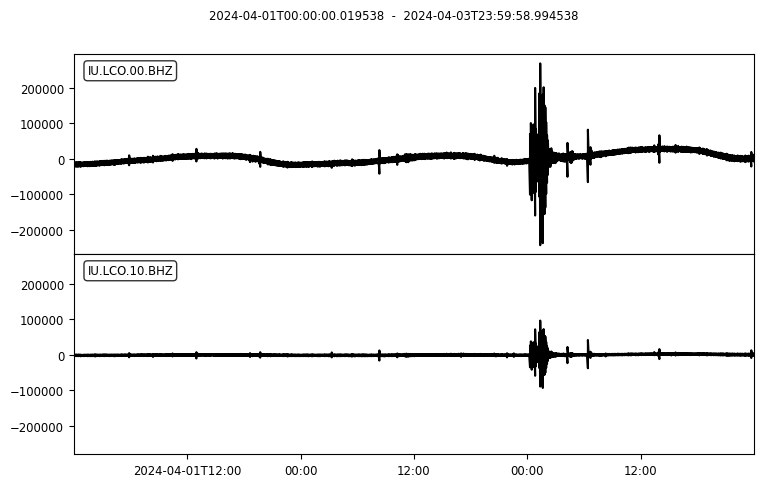

In [ ]:
from obspy import read, Stream

# Specify the network, station, channels, start time, and end time
network = "IU"         # Network code
station = "LCO"        # Station code
seismic_channel = "BHZ"   # Channel code for the seismic waveform data
magnitude_channel = "MN"  # Channel code for the earthquake magnitude data
start_time = "2024-04-01T00:00:00"  # Start time of data retrieval
end_time = "2024-04-03T23:59:59"    # End time of data retrieval

# Construct the query URL to retrieve data for the specified channels
query_url = f"http://service.iris.edu/fdsnws/dataselect/1/query?\
net={network}&sta={station}&\
channel={seismic_channel},{magnitude_channel}&\
start={start_time}&end={end_time}&format=miniseed"

# List to store stream objects
stream_list = []

# Retrieve data from the specified channels
try:
    # Read data from the specified URL
    stream = read(query_url)

    # Append the retrieved stream to the list of streams
    stream_list.append(stream)

except Exception as e:
    # Print an error message if data retrieval fails
    print(f"Error retrieving data: {e}")

# Combine all streams into a single stream
combined_stream = Stream()
for stream in stream_list:
    combined_stream += stream

# Plot the combined stream
combined_stream.plot()


In [ ]:
import numpy as np

# Define a function to generate random sample data (replace with actual streaming code)
def read_next_sample():
    return np.random.rand()  # Placeholder code to generate random sample data

# Initialize an empty list to buffer the streaming data
buffered_data = []

# Define the number of samples to stream
num_samples_to_stream = 1000  # Adjust this value as needed

# Simulated streaming of seismic data
for _ in range(num_samples_to_stream):
    # Read a sample of seismic waveform data
    sample_data = read_next_sample()  # Replace with code to read a sample from the streaming source

    # Append the sample data to the buffer
    buffered_data.append(sample_data)

# Convert the buffered data to a NumPy array
seismic_data = np.array(buffered_data)

# Now 'seismic_data' is a NumPy array containing the streaming seismic waveform data


In [ ]:

# Compute mean, median, standard deviation, minimum, and maximum values
mean_value = np.mean(seismic_data)
median_value = np.median(seismic_data)
std_deviation = np.std(seismic_data)
min_value = np.min(seismic_data)
max_value = np.max(seismic_data)

# Print the computed summary statistics
print("Mean:", mean_value)
print("Median:", median_value)
print("Standard Deviation:", std_deviation)
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)


Mean: 0.48539733889026854
Median: 0.46470781462566385
Standard Deviation: 0.29039470460608635
Minimum Value: 0.00022354411327762946
Maximum Value: 0.9983895353951493
